<a href="https://colab.research.google.com/github/mukthar56788/Data-science-projects/blob/main/Breed_prediction_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required libraries (usually pre-installed in Colab, but included for completeness)
!pip install tensorflow tensorflow-datasets

# Import libraries
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Load the Oxford-IIIT Pet Dataset
ds_train, ds_test = tfds.load('oxford_iiit_pet', split=['train', 'test'], as_supervised=True)

# Preprocessing function
def preprocess(image, label):
    image = tf.image.resize(image, [64, 64])  # Resize to 64x64
    image = image / 255.0  # Normalize to [0, 1]
    label = tf.one_hot(label, 37)  # One-hot encode for 37 classes
    return image, label

# Apply preprocessing and batch the data
BATCH_SIZE = 32
ds_train = ds_train.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Convert dataset to NumPy arrays
def dataset_to_numpy(dataset):
    images, labels = [], []
    for img, lbl in tfds.as_numpy(dataset):
        images.append(img)
        labels.append(lbl)
    return np.concatenate(images), np.concatenate(labels)

x_train_full, y_train_full = dataset_to_numpy(ds_train)
x_test, y_test = dataset_to_numpy(ds_test)

# Split train into train (80%) and validation (20%)
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x_train_full, y_train_full, test_size=0.2, random_state=42)

# Print shapes to verify
print('x_train shape:', x_train.shape)
print('x_valid shape:', x_valid.shape)
print('x_test shape:', x_test.shape)

x_train shape: (2944, 64, 64, 3)
x_valid shape: (736, 64, 64, 3)
x_test shape: (3669, 64, 64, 3)


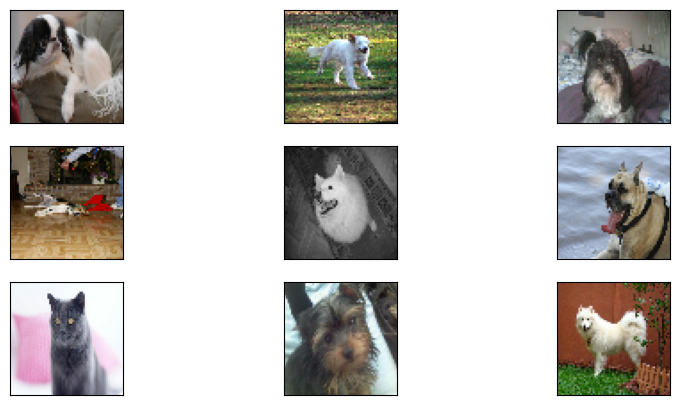

In [ ]:
# Visualize a few images
fig = plt.figure(figsize=(10, 5))
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(x_train[i])
plt.show()

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.4),
    Dense(37, activation='softmax')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       4,195,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 37)                  │          37,925 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,621,669 (17.63 MB)

 Trainable params: 4,621,669 (17.63 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),  # Lower learning rate
    metrics=['accuracy']
)

In [ ]:
# Define data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='nearest'
)

datagen.fit(x_train)

# Set up checkpoint
checkpointer = ModelCheckpoint(
    filepath='model.weights.best.keras',
    verbose=1,
    save_best_only=True
)

# Train with augmented data
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
    epochs=500,
    validation_data=(x_valid, y_valid),
    callbacks=[checkpointer],
    verbose=2
)

Epoch 1/500


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 3.60923, saving model to model.weights.best.keras
92/92 - 11s - 116ms/step - accuracy: 0.0234 - loss: 3.6174 - val_accuracy: 0.0353 - val_loss: 3.6092
Epoch 2/500

Epoch 2: val_loss improved from 3.60923 to 3.60709, saving model to model.weights.best.keras
92/92 - 4s - 40ms/step - accuracy: 0.0319 - loss: 3.6051 - val_accuracy: 0.0367 - val_loss: 3.6071
Epoch 3/500

Epoch 3: val_loss improved from 3.60709 to 3.57921, saving model to model.weights.best.keras
92/92 - 5s - 51ms/step - accuracy: 0.0442 - loss: 3.5932 - val_accuracy: 0.0380 - val_loss: 3.5792
Epoch 4/500

Epoch 4: val_loss improved from 3.57921 to 3.54908, saving model to model.weights.best.keras
92/92 - 4s - 41ms/step - accuracy: 0.0547 - loss: 3.5625 - val_accuracy: 0.0421 - val_loss: 3.5491
Epoch 5/500

Epoch 5: val_loss improved from 3.54908 to 3.50191, saving model to model.weights.best.keras
92/92 - 4s - 41ms/step - accuracy: 0.0628 - loss: 3.5232 - val_accuracy: 0.0625 - val_lo

In [ ]:
# Load the best weights
model.load_weights('model.weights.best.keras')

# Evaluate on test set
score = model.evaluate(x_test, y_test, verbose=0)
print('\nTest accuracy:', score[1])


Test accuracy: 0.3025347590446472


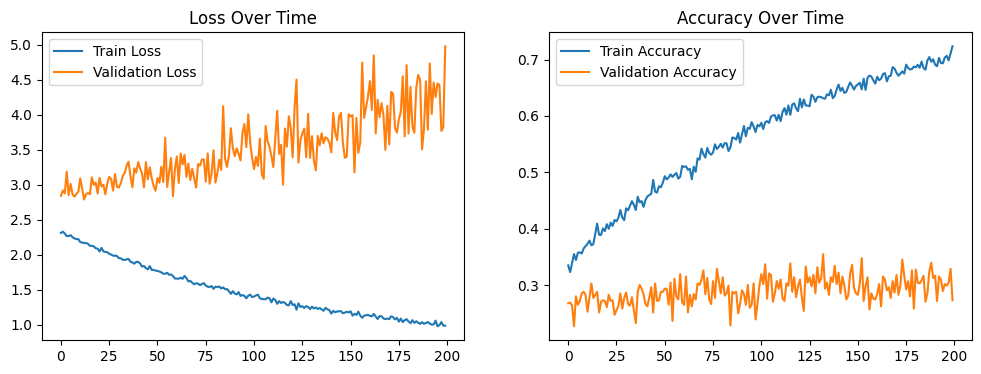

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Time')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Time')
plt.legend()
plt.show()

In [ ]:
# Define the 37 class names for Oxford-IIIT Pet Dataset
class_names = [
    'Abyssinian', 'American Bulldog', 'American Pit Bull Terrier', 'Basset Hound',
    'Beagle', 'Bengal', 'Birman', 'Bombay', 'Boxer', 'British Shorthair',
    'Chihuahua', 'Egyptian Mau', 'English Cocker Spaniel', 'English Setter',
    'German Shorthaired', 'Great Pyrenees', 'Havanese', 'Japanese Chin',
    'Keeshond', 'Leonberger', 'Maine Coon', 'Miniature Pinscher', 'Newfoundland',
    'Persian', 'Pomeranian', 'Pug', 'Ragdoll', 'Rottweiler', 'Russian Blue',
    'Saint Bernard', 'Samoyed', 'Scottish Terrier', 'Shiba Inu', 'Siamese',
    'Sphynx', 'Staffordshire Bull Terrier', 'Wheaten Terrier', 'Yorkshire Terrier'
]

Saving Bengal_111.jpg to Bengal_111.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


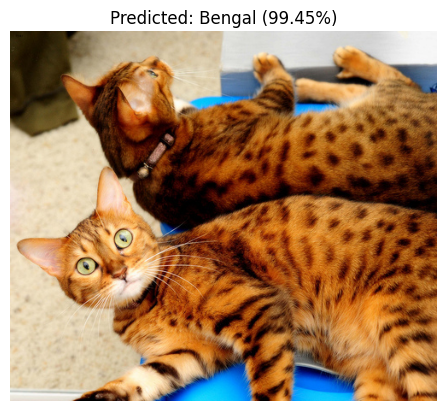

Predicted class: Bengal with confidence 99.45%


In [ ]:
# Import required libraries for image handling
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained model with best weights
model.load_weights('model.weights.best.keras')

# Function to preprocess a single image
def preprocess_image(img_path):
    # Load image and resize to 64x64 (match training input shape)
    img = image.load_img(img_path, target_size=(64, 64))
    # Convert to array
    img_array = image.img_to_array(img)
    # Normalize to [0, 1]
    img_array = img_array / 255.0
    # Expand dimensions to match model input (1, 64, 64, 3)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Upload an image from your local machine
uploaded = files.upload()

# Process and predict for each uploaded image
for filename in uploaded.keys():
    # Preprocess the image
    img_array = preprocess_image(filename)

    # Make prediction
    prediction = model.predict(img_array)

    # Get the predicted class index and confidence
    predicted_class_idx = np.argmax(prediction[0])
    confidence = prediction[0][predicted_class_idx]

    # Map index to class name
    predicted_class = class_names[predicted_class_idx]

    # Display the image
    plt.figure()
    plt.imshow(image.load_img(filename))
    plt.title(f'Predicted: {predicted_class} ({confidence:.2%})')
    plt.axis('off')
    plt.show()

    # Print result
    print(f'Predicted class: {predicted_class} with confidence {confidence:.2%}')